# PS4E7 - Binary Classification of Insurance Cross Selling 🤝

# Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
import xgboost

from lightgbm import LGBMClassifier
import lightgbm

In [3]:
train = pd.read_csv("./input/train.csv", index_col="id")
test = pd.read_csv("./input/test.csv", index_col="id")

original_train = pd.read_csv("./input/original_train.csv", index_col="id")

# Dataset description

- id -> Unique ID for the customer;
- Gender ->Gender of the customer;
- Age ->Age of the customer;
- Driving_License ->0 : Customer does not have DL, 1 : Customer already has DL;
- Region_Code ->Unique code for the region of the customer;
- Previously_Insured ->1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance;
- Vehicle_Age ->Age of the Vehicle;
- Vehicle_Damage ->1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past;
- Annual_Premium ->The amount customer needs to pay as premium in the year;
- Policy_Sales_Channel ->Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc;
- Vintage ->Number of Days, Customer has been associated with the company;
- Response ->1 : Customer is interested, 0 : Customer is not interested;

Thanks to @gauravduttakiit for sharing [here](https://www.kaggle.com/competitions/playground-series-s4e7/discussion/515975).

# Transforming Data Types

In [4]:
def transform_dtypes(data, is_train=False):
    data["Gender"] = data["Gender"].apply(lambda x: True if x == "Male" else False)
    data["Vehicle_Damage"] = data["Vehicle_Damage"].apply(lambda x: True if x == "Yes" else False)
    data[["Driving_License", "Previously_Insured"]] = data[["Driving_License", "Previously_Insured"]].astype("bool")
    
    data[["Region_Code", "Vehicle_Age", "Policy_Sales_Channel"]] = data[["Region_Code", "Vehicle_Age", "Policy_Sales_Channel"]].astype("category")
    
    data["Age"] = data["Age"].astype("int8")
    data["Vintage"] = data["Vintage"].astype("int16")

    if is_train: data["Response"] = data["Response"].astype("bool")

## Synthetic

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Gender                object 
 1   Age                   int64  
 2   Driving_License       int64  
 3   Region_Code           float64
 4   Previously_Insured    int64  
 5   Vehicle_Age           object 
 6   Vehicle_Damage        object 
 7   Annual_Premium        float64
 8   Policy_Sales_Channel  float64
 9   Vintage               int64  
 10  Response              int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.0+ GB


Let's change some dtypes for optmization!

In [6]:
transform_dtypes(train, is_train=True)
transform_dtypes(test)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Dtype   
---  ------                -----   
 0   Gender                bool    
 1   Age                   int8    
 2   Driving_License       bool    
 3   Region_Code           category
 4   Previously_Insured    bool    
 5   Vehicle_Age           category
 6   Vehicle_Damage        bool    
 7   Annual_Premium        float64 
 8   Policy_Sales_Channel  category
 9   Vintage               int16   
 10  Response              bool    
dtypes: bool(5), category(3), float64(1), int16(1), int8(1)
memory usage: 307.2 MB


## Original

In [8]:
transform_dtypes(original_train, is_train=True)

In [9]:
original_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 381109 entries, 1 to 381109
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Gender                381109 non-null  bool    
 1   Age                   381109 non-null  int8    
 2   Driving_License       381109 non-null  bool    
 3   Region_Code           381109 non-null  category
 4   Previously_Insured    381109 non-null  bool    
 5   Vehicle_Age           381109 non-null  category
 6   Vehicle_Damage        381109 non-null  bool    
 7   Annual_Premium        381109 non-null  float64 
 8   Policy_Sales_Channel  381109 non-null  category
 9   Vintage               381109 non-null  int16   
 10  Response              381109 non-null  bool    
dtypes: bool(5), category(3), float64(1), int16(1), int8(1)
memory usage: 10.2 MB


# Data in a glance

## Train data

In [10]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,True,21,True,35.0,False,1-2 Year,True,65101.0,124.0,187,False
1,True,43,True,28.0,False,> 2 Years,True,58911.0,26.0,288,True
2,False,25,True,14.0,True,< 1 Year,False,38043.0,152.0,254,False
3,False,35,True,1.0,False,1-2 Year,True,2630.0,156.0,76,False
4,False,36,True,15.0,True,1-2 Year,False,31951.0,152.0,294,False


In [11]:
train.describe()

,Age,Annual_Premium,Vintage
count,1.150480e+07,1.150480e+07,1.150480e+07
mean,3.838356e+01,3.046137e+04,1.638977e+02
std,1.499346e+01,1.645475e+04,7.997953e+01
min,2.000000e+01,2.630000e+03,1.000000e+01
25%,2.400000e+01,2.527700e+04,9.900000e+01
50%,3.600000e+01,3.182400e+04,1.660000e+02
75%,4.900000e+01,3.945100e+04,2.320000e+02
max,8.500000e+01,5.401650e+05,2.990000e+02


In [12]:
train.select_dtypes(include=['category', 'bool']).describe()

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel,Response
count,11504798,11504798,11504798.0,11504798,11504798,11504798,11504798.0,11504798
unique,2,2,54.0,2,3,2,152.0,2
top,True,True,28.0,False,1-2 Year,True,152.0,False
freq,6228134,11482041,3451062.0,6178116,5982678,5783229,4166183.0,10089739


In [13]:
train.isna().value_counts()

Gender  Age    Driving_License  Region_Code  Previously_Insured  Vehicle_Age  Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  Response
False   False  False            False        False               False        False           False           False                 False    False       11504798
Name: count, dtype: int64

No missing values!

## Original dataset

In [14]:
original_train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,True,44,True,28.0,False,> 2 Years,True,40454.0,26.0,217,True
2,True,76,True,3.0,False,1-2 Year,False,33536.0,26.0,183,False
3,True,47,True,28.0,False,> 2 Years,True,38294.0,26.0,27,True
4,True,21,True,11.0,True,< 1 Year,False,28619.0,152.0,203,False
5,False,29,True,41.0,True,< 1 Year,False,27496.0,152.0,39,False


In [15]:
original_train.describe()

,Age,Annual_Premium,Vintage
count,381109.000000,381109.000000,381109.000000
mean,38.822584,30564.389581,154.347397
std,15.511611,17213.155057,83.671304
min,20.000000,2630.000000,10.000000
25%,25.000000,24405.000000,82.000000
50%,36.000000,31669.000000,154.000000
75%,49.000000,39400.000000,227.000000
max,85.000000,540165.000000,299.000000


Same statistics as train dataset

In [16]:
original_train.select_dtypes(include=['category', 'bool']).describe()

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel,Response
count,381109,381109,381109.0,381109,381109,381109,381109.0,381109
unique,2,2,53.0,2,3,2,155.0,2
top,True,True,28.0,False,1-2 Year,True,152.0,False
freq,206089,380297,106415.0,206481,200316,192413,134784.0,334399


# EDA

This dataset is huge. We'll sample it for our visualizations

In [17]:
# frac = .033 so our sample size is close to original data size. It will make easier to compare them both.
train_sample = train.sample(frac=.033, random_state=42)

## Synthetic vs Original dataset

Is the Original Dataset close to our Synthetic one? Could it improve our model's performance?

In [18]:
train_sample["original"] = False
original_train["original"] = True

together = pd.concat([train_sample, original_train])
together['Vehicle_Age'] = together['Vehicle_Age'].cat.codes
together['Response'] = together['Response'].astype('bool')

train_sample.drop(inplace=True, columns=["original"])
original_train.drop(inplace=True, columns=["original"])

together.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,original
id,,,,,,,,,,,,
2899125,False,41,True,28.0,False,0,True,29590.0,157.0,46,False,False
3854901,False,40,True,28.0,False,0,True,42910.0,13.0,245,False,False
7377384,True,31,True,18.0,False,1,True,30375.0,152.0,31,False,False
10901782,False,24,True,37.0,True,1,False,2630.0,152.0,217,False,False
8099641,True,33,True,28.0,True,0,False,45224.0,124.0,286,False,False


Synthetic vs Original Means

In [19]:
together.groupby(['original']).mean()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
original,,,,,,,,,,,
False,0.540739,38.389100,0.997914,26.400927,0.462903,0.521401,0.503743,30499.001691,112.269751,163.965701,0.122998
True,0.540761,38.822584,0.997869,26.388807,0.458210,0.516388,0.504877,30564.389581,112.034295,154.347397,0.122563


Synthetic vs Original Medians

In [20]:
together.groupby(['original']).median()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
original,,,,,,,,,,,
False,1.0,36.0,1.0,28.0,0.0,0.0,1.0,31851.0,150.0,166.0,0.0
True,1.0,36.0,1.0,28.0,0.0,0.0,1.0,31669.0,133.0,154.0,0.0


Synthetic vs Original Standard Deviations

In [21]:
together.groupby(['original']).std()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
original,,,,,,,,,,,
False,0.498338,15.004783,0.045626,12.992345,0.498623,0.576447,0.499987,16353.503020,54.111915,80.038525,0.328435
True,0.498336,15.511611,0.046110,13.229888,0.498251,0.577698,0.499977,17213.155057,54.203995,83.671304,0.327936


Synthetic vs Original Skewness

In [22]:
together.groupby(['original']).skew()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
original,,,,,,,,,,,
False,-0.163501,0.636919,-21.825948,-0.128463,0.148797,0.564504,-0.014972,0.505003,-0.907973,-0.109498,2.295764
True,-0.163590,0.672539,-21.595182,-0.115266,0.167747,0.589682,-0.019507,1.766087,-0.900008,0.003030,2.301906


Text(0, 0.5, '')

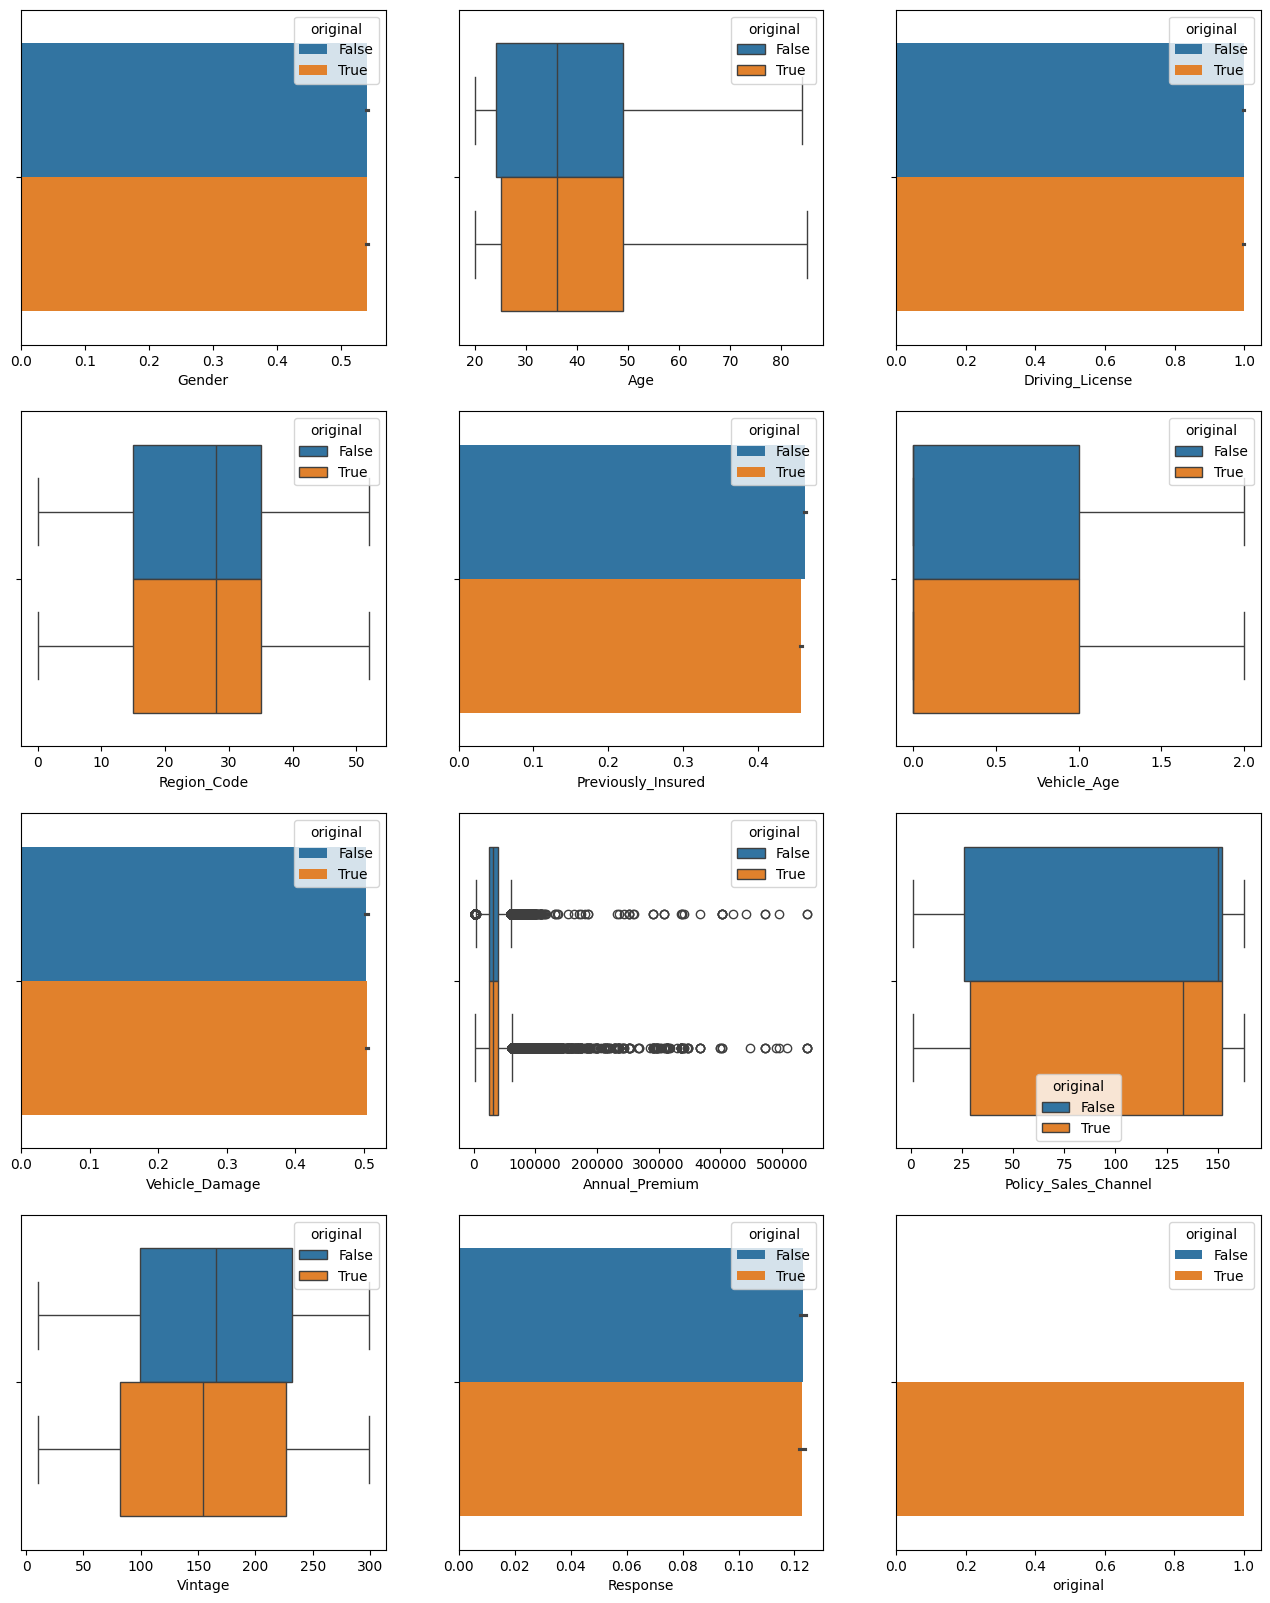

In [23]:
reshaped = np.reshape(together.columns, (4,3))

_, axs = plt.subplots(4, 3, figsize=(16, 20))

for i in range(4):
    for j in range(3):
        if (pd.api.types.is_bool_dtype(together[reshaped[i][j]].dtype)):
            ax = sns.barplot(x=together[reshaped[i][j]], ax=axs[i][j], hue=together["original"])
        else:
            ax = sns.boxplot(x=together[reshaped[i][j]], ax=axs[i][j], hue=together["original"])
        ax.set_ylabel(None)
        
ax.set_ylabel(None)

Distributions and statistics are very similar visually save for a few cases.

We'll use Chi-Square tests to check that.

In [54]:
import pandas as pd
from scipy.stats import chi2_contingency, ks_2samp

def compare_distributions(original, synthetic):
    test_results = {}

    for column in original.columns:
        if (pd.api.types.is_categorical_dtype(original[column]) or pd.api.types.is_bool_dtype(original[column])):
            contingency_table = pd.crosstab(original[column], synthetic[column], dropna=False)
            # Add a small constant to avoid zero frequencies
            contingency_table += 0.5
            
            stat, p_value, _, _ = chi2_contingency(contingency_table)
            
            test_results[column] = {
                'Test': 'Chi^2',
                'Statistic': stat,
                'P_value': p_value,
                'Statistically significant (different distributions)': p_value < 0.05
            }
        else:
            stat, p_value, _, _ = ks_2samp(original, synthetic)

            test_results[column] = {
                'Test': 'Kolmogorov-Smirnov',
                'Statistic': stat,
                'P_value': p_value,
                'Statistically significant (different distributions)': p_value < 0.05
            }
    
    return pd.DataFrame(test_results).T

In [55]:
compare_distributions(original_train, train_sample)

ValueError: could not convert string to float: '1-2 Year'

Since the original data didn't hurt model performance, I'll use it for now.

In [ ]:
# train_sample = pd.concat([train_sample, original_train])
# categorical_columns = ["Region_Code", "Vehicle_Age", "Policy_Sales_Channel"]
# train_sample[categorical_columns] = train_sample[categorical_columns].astype("category")
del together

## Feature Distribution

### Numeric Features

In [ ]:
_, axs = plt.subplots(1, 3, figsize=(16,4))

sns.histplot(x=train_sample["Age"], ax=axs[0], bins=30, kde=True, hue=train_sample["Response"]).set_ylabel(None)
sns.histplot(x=train_sample["Annual_Premium"], ax=axs[1], bins=30, kde=True, hue=train_sample["Response"]).set_ylabel(None)
sns.histplot(x=train_sample["Vintage"], ax=axs[2], bins=30, kde=True, hue=train_sample["Response"]).set_ylabel(None)

### Categorical Features

In [ ]:
categorical_columns = train_sample.select_dtypes("category").columns

_, axs = plt.subplots(3, 1, figsize=(10,16))

for i in range(3):
    ax = sns.countplot(x=train_sample[categorical_columns[i]], ax=axs[i], hue=train_sample["Response"])
    ax.set_ylabel(None)
    ax.tick_params(axis='x', rotation=90)

### Boolean Features

In [ ]:
boolean_columns = train_sample.select_dtypes("bool").columns
reshaped_bools = np.reshape(boolean_columns[:-1], (2,2))

_, axs = plt.subplots(2, 2, figsize=(12, 10))

for i in range(2):
    for j in range(2):
        sns.countplot(x=train_sample[reshaped_bools[i][j]], ax=axs[i][j], hue=train_sample["Response"]).set_ylabel(None)

## Target Balance

In [ ]:
sns.countplot(x=train_sample["Response"])

In [ ]:
rate = str(len(train_sample[train_sample["Response"] == True]) / len(train_sample[train_sample["Response"] == False]) * 100)
print(f"True/False: {rate}%")

## Mutual Information

In [ ]:
def make_mi_scores(X, y):
    X = X.copy()
    X['Vehicle_Age'] = X['Vehicle_Age'].cat.codes
    
    mi_scores = mutual_info_regression(X, y, random_state=42, discrete_features=True)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=True)
    return mi_scores

mi_scores = make_mi_scores(train_sample.drop(columns="Response"), train_sample["Response"])

In [ ]:
mi_scores.plot.barh(figsize=(12,8))

## Correlation

In [ ]:
def plot_correlation(data):
    data = data.copy()
    data['Vehicle_Age'] = data['Vehicle_Age'].cat.codes
    corr_matrix = data.corr()
    
    plt.figure(figsize=(12,8))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    return sns.heatmap(corr_matrix, mask=mask, center=0)

In [ ]:
plot_correlation(train_sample)

## Feature Importance

In [ ]:
fi_xgb = XGBClassifier(random_state=42, enable_categorical=True, n_jobs=-1, eval_metric="auc")
fi_lgbm = LGBMClassifier(random_state=42, verbose=0, n_jobs=-1)

fi_xgb.fit(train_sample.drop(columns='Response'), train_sample.Response)
fi_lgbm.fit(train_sample.drop(columns='Response'), train_sample.Response, eval_metric="auc")

In [ ]:
_, axs = plt.subplots(3, 1, figsize=(14, 18))

xgboost.plot_importance(fi_xgb, ax=axs[0], title="XGBoost Feature Importance", xlabel=None, ylabel=None, importance_type="gain", values_format="{v:.2f}")
lightgbm.plot_importance(fi_lgbm, ax=axs[1], title="LightGBM Feature Importance", xlabel=None, ylabel=None, importance_type="gain", precision=2)

# Model Evaluation

In [27]:
X = train_sample.drop(columns="Response")
y = train_sample.Response

## Data Scaling

Standard Scaling on numeric features offered a small improvement on model scoring

In [28]:
numeric_columns = X.select_dtypes('number').columns

transformer = ColumnTransformer([("scaler", StandardScaler(), numeric_columns)])
X[numeric_columns] = transformer.fit_transform(X)

## XGBoost

In [29]:
xgb = XGBClassifier(random_state=42, enable_categorical=True, n_jobs=-1, eval_metric="auc")

cross_val_score(xgb, X, y, cv=5, n_jobs=-1).mean()

0.8778637602033369

0.8770241060022302

## LGBM

In [30]:
lgbm = LGBMClassifier(random_state=42, verbose=0, n_jobs=-1)

cross_val_score(lgbm, X, y, cv=5, n_jobs=-1, params={'eval_metric': "auc"}).mean()

0.8784643016888298

0.8772068183293985